In [1]:
import torch
from torch.utils.data import DataLoader
import sys
from plyfile import PlyData
import numpy as np
from tqdm import tqdm
from glob import glob
from os import path
sys.path.append('../')
from pointnet.dataset import OctantDataset, collate_batched_point_clouds, lm2flat_index
from pointnet.metrics import camera_color
from pointnet.sh import to_spherical,calc_sh

/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def camera_positions(filename: str) -> torch.Tensor:
    plydata = PlyData.read(filename)
    vertex_data = plydata["vertex"].data

    def unpack_data(data, field_names):
        return torch.from_numpy(np.stack([data[key] for key in field_names]).T)

    cameras = unpack_data(vertex_data, ["x", "y", "z"])
    return to_spherical(cameras)

cameras_pos = camera_positions("../sphere.ply")
cameras_pos.shape

torch.Size([162, 2])

In [6]:
bunny = OctantDataset("../datasets/bunny/octants_8192max_sh",load_cam_colors=True)[0]

In [8]:
pc,coefs,cam_colors = bunny

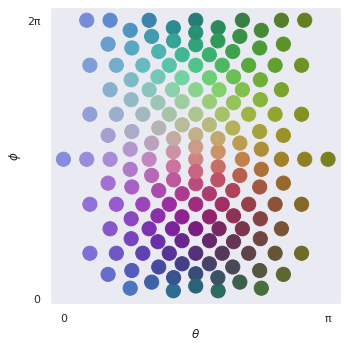

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


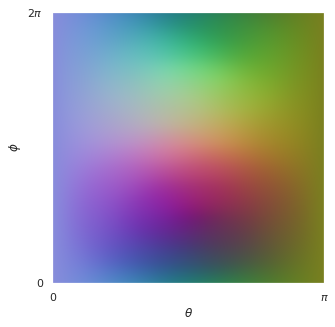

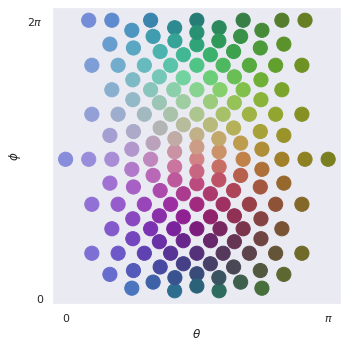

In [80]:
res = 256
x = torch.arange(0,1,1/res)
x_grid,y_grid = torch.meshgrid([x*torch.pi,(1-x)*torch.pi*2],indexing="ij")
coords = torch.stack([x_grid,y_grid]).flatten(1)
l = 10
y = calc_sh(l,coords.T)
img = (y@coefs[:lm2flat_index(l,l)+1]).reshape(res,res,3)
plt.figure(figsize=(5,5))
plt.imshow(img.permute(1,0,2))
plt.yticks([0,res],["$2\\pi$","0"])
plt.xticks([0,res],["0","$\\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\\phi$")
plt.grid(False)
plt.savefig("bunny_example/sh_image.svg")


plt.figure(figsize=(5,5))
plt.scatter(cameras_pos[:,0],cameras_pos[:,1],c=cam_colors,s=200)
plt.yticks([0,torch.pi*2],["0","$2\\pi$"])
plt.xticks([0,torch.pi],["0","$\\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\\phi$")
plt.tight_layout()
plt.grid(False)
plt.savefig("bunny_example/camera_colors.svg")